In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import random

In [2]:
f_name = 'ECG200_TRAIN'

def random_repeat():
    x = random.randint(2, 4)
    return x

with open(f_name, 'r') as f:
    ts = f.read()
    ts = [[float(i) for i in t.split()]*random_repeat() for t in ts.split('\n')]

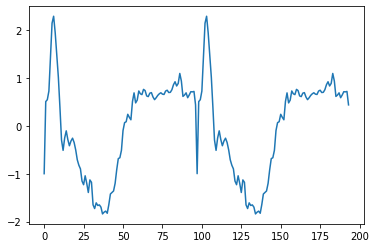

In [3]:
plt.plot(ts[0])

In [4]:
def z_norm(arr):
    return stats.zscore(arr)

In [5]:
WINDOW_SIZE = 4 # windows size

beta = [-0.97, -0.43, 0.0, 0.43, 0.97] # cut off point
symbol = ['A', 'B', 'C', 'D', 'E', 'F'] # alphabet of SAX

def to_SAX(arr, window_size=WINDOW_SIZE, cutoff=beta, symbol=symbol):
    i = 0
    PCA = []
    while i < len(arr):
        m = np.mean(arr[i: i+window_size])
        PCA.append(m)
        i += window_size
    PCA_norm = z_norm(PCA)
    out = ''
    for i in PCA_norm:
        j = 0
        while j < len(cutoff) and i > cutoff[j]:
            j += 1
        out += symbol[j]
    return out

In [6]:
SAXs = [to_SAX(i) for i in ts]

In [7]:
import numpy as np
import random
from copy import deepcopy

strings = deepcopy(SAXs)
motif_len = 30

def gibbs():
    binding_sites = []
    count = np.ones((motif_len, 6))

    d = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5}
    def insert_str(string):
        for i, c in enumerate(string):
            count[i][d[c]] += 1

    def remove_str(string):
        for i, c in enumerate(string):
            count[i][d[c]] -= 1

    for string in strings:
        pos = random.randint(motif_len, len(string))
        rand_str = string[pos - motif_len: pos]
        binding_sites.append(rand_str)
        insert_str(rand_str)

    def calculate_score(string):
        score = 1.0
        for i, c in enumerate(string):
            score *= count[i][d[c]]/(len(strings)+2)
        return score

    improvement = True
    while improvement:
        improvement = False
        for i, string in enumerate(strings):
            previous_best_match = binding_sites[i]
            best_score = calculate_score(previous_best_match)
            best_match = previous_best_match
            for j in range(motif_len, len(string)):
                new_str = string[j-motif_len: j]
                if calculate_score(new_str) > best_score:
                    best_match = new_str
                    best_score = calculate_score(best_match)
            if best_match != previous_best_match:
                improvement = True
                remove_str(previous_best_match)
                insert_str(best_match)
                binding_sites[i] = best_match

    return count, binding_sites


count, binding_sites = gibbs()
# binding_sites_location = [string.find(binding_site) + 1 for binding_site, string in zip(binding_sites, strings)]

print(f'{binding_sites = }')
# print(f'{binding_sites_location = }')


binding_sites = ['DEEEEEEEFEEDFFCCBAAAAAABDEEEEE', 'DEFFEEEEEECCBBDFCDBAAAAACEFFEE', 'DEEEEEEEEEEDFFCCBAAAAAACDEEEEE', 'DEDDDDDDEFEFFEECCBAAAAABDEEDDD', 'EFEEEEDDEEDCCCEFEDBAAAAADFEEEE', 'DEEEEEEEEEDDDDEFCCAAAAABDEEEEE', 'DEEEEEEEEEEFECCBBBAAAAACDEEEEE', 'DEEEEEEEEDDDCFFCCBBAAAABDEEEEE', 'DFFEEEEEEEDDDCEFBCAAAAAADEFEEE', 'EEEEEDDDDEDCCCFFFCAAAAABEEEEEE', 'DEEEEEEFEDCDEFEDDBBAAAABDEEEEE', 'DEEEEEEEEEDDEFEDCBAAAAACDEEEEE', 'DEDCDEEEEFEDDDEFCBAAAAAACEDDDE', 'EFEEEEDDEDCCBBFFEDBAAAABDFEEEE', 'CDEEEEEEEDFFEDCCBBAAAAABCDEEEE', 'EEEEEDDDDDDCCCEFFDBAAAAADEEEED', 'EFEEEEDDDEDCCCDFDCBAAAAADEFEEE', 'DEEEEEEDDECCCBCFEEBAAAAACEEEEE', 'CDDDDEEEEEDDFFEFDAAAAAAACDDDDD', 'DDDDEEEEEEEDFFCCBBAAAAABDDDDEE', 'DEEEEEEFEEDDDFECBBBAAAABDEEEEE', 'EEEEEEEDEEEEEEEFDBAAAAAADEEEEE', 'DFFEEEDDEEDCCCEFBCBAAAAACEEEEE', 'FFFEDDDDCCDDDCCCDFEAAAAAEFFEED', 'EEEEEEEDDEDCCCDFDDBAAAAADEEEEE', 'EEEEEEDEDEEDDDEFEDBAAAAADEEEEE', 'DEEEEEEDEEDDDDEFEEBAAAAADEEEEE', 'DEEDDEDDFFDEECBBBABAAAABDEEDDD', 'DFEEEEEEEEEDEDEEDCBAAAAADEFEEE

In [8]:
best_binding_site = binding_sites[0]

In [9]:
def get_dist(i, j, cutoff, symbol):
    i, j = symbol.index(i), symbol.index(j)
    if abs(i-j) <= 1:
        return 0
    return cutoff[max(i, j) - 1] - cutoff[min(i, j)]

def get_euclidean_min_dist(a, b, cutoff=beta, symbol=symbol, window_size=WINDOW_SIZE):
    sum_square = 0
    for i, j in zip(a, b):
        sum_square += get_dist(i, j, cutoff, symbol) ** 2
    return (sum_square * window_size) ** .5

def find_best_bind(arr, sax, binding_site):
    best_score = 1e20
    best_arr = None
    arr = arr * 2
    sax = sax * 2
    l_bound = None
    r_bound = None
    for i in range(len(binding_site), len(sax)):
        sub_str = sax[i-len(binding_site): i]
        score = get_euclidean_min_dist(sub_str, binding_site)
        if score < best_score:
            best_score = score
            l_bound = (i-len(binding_site)) * WINDOW_SIZE
            r_bound = i * WINDOW_SIZE
            best_arr = arr[l_bound: r_bound]
    return best_arr, l_bound, r_bound

In [10]:
def get_best_site(i):
    return find_best_bind(ts[i], SAXs[i], best_binding_site)

In [11]:
tss = []
bound = []
for i in range(len(ts)):
    data, l_bound, r_bound = get_best_site(i)
    tss.append(data)
    bound.append((l_bound, r_bound))

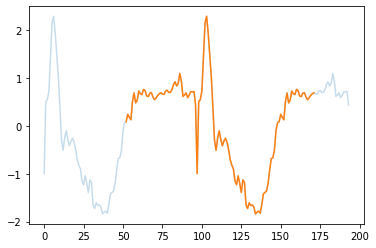

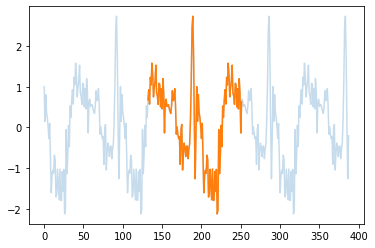

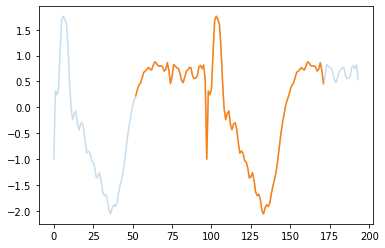

In [12]:
def plot_motif_on_original(index):
    plt.plot(ts[index], alpha=0.25)
    plt.plot(np.arange(bound[index][0], bound[index][1]), tss[index])
    plt.show()
    
plot_motif_on_original(0)
plot_motif_on_original(1)
plot_motif_on_original(2)

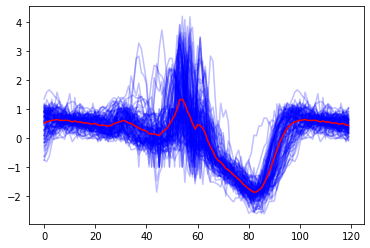

In [13]:
for data in tss:
    plt.plot(data, color="blue", alpha=0.25)
    
average_shape = np.mean(tss, axis=0)
plt.plot(average_shape, color="red")
plt.plot()
plt.show()